# **<p style="text-align: center;">Анализ успешности игр в интернет-магазине «Стримчик».</p>**

Будем анализировать интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам предстоит выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Откроем файл с данными и изучим общую информацию.

### Импорт необходимых библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
import plotly.express as px

### Загрузка данных.

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Описание данных:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Изучим общую информацию.

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games.columns = games.columns.str.lower()

In [5]:
duplicate_rows = games.duplicated().sum()
print("Количество явных дубликатов:", duplicate_rows)

Количество явных дубликатов: 0


In [6]:
duplicate_rows = games.duplicated(subset=['name', 'platform', 'year_of_release']).sum()
print("Количество неявных дубликатов:", duplicate_rows)

Количество неявных дубликатов: 2


In [7]:
games.drop_duplicates(subset=['name', 'platform', 'year_of_release'], inplace=True)

В данных отсутствуют явные дубликаты строк.
    
Было обнаружено 2 неявных дубликата в данных, содержащих одинаковые значения для столбцов 'name', 'platform' и 'year_of_release'. Эти дубликаты были удалены из набора данных.


## Подготовим данные.

### Заменим названия столбцов (приведем к нижнему регистру).

In [8]:
games.rename(columns=lambda x: x.lower(), inplace=True)
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработаем пропуски.

In [9]:
games.isnull().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         6700
rating             6765
dtype: int64

In [10]:
games = games.dropna(subset=['name'])
games = games.dropna(subset=['year_of_release'])

In [11]:
games['critic_score'].describe()

count    7982.000000
mean       68.992608
std        13.920049
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [13]:
games['critic_score'] = games['critic_score'].fillna(-1)

    
Пропуски в столбце 'critic_score' заполнены отрицательной цифрой, которая может служить в качестве заглушки для обозначения пропущенных данных.    


In [14]:
games.loc[(games['user_score'] == 'tbd')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,-1.0,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,-1.0,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.0,0.18,-1.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,-1.0,tbd,E


In [15]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')
games.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score         8981
rating             6676
dtype: int64

In [16]:
games['user_score'].describe()

count    7462.000000
mean        7.126548
std         1.499429
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

In [18]:
games['user_score'] = games['user_score'].fillna(-1)


Пропуски в столбце 'user_score' заполнены отрицательной цифрой, которая может служить в качестве заглушки для обозначения пропущенных данных. 
    
***Причины появления пропусков в столбцах 'critic_score' и 'user_score' могут быть следующими:***

- Отсутствие оценки: Некоторые игры могут не иметь оценки от критиков или пользователей. Это может быть связано с тем, что игра была выпущена недавно или не привлекла достаточное внимание для получения оценки.

- Ошибки в сборе данных: В процессе сбора данных могли возникнуть ошибки, в результате чего оценки не были записаны для некоторых игр.

- Неполные данные: В некоторых случаях данные об оценках могут быть неполными или отсутствовать из-за технических проблем или ошибок при передаче или хранении данных.


В столбце "Critic_Score" возможные причины пропусков могут быть следующими.Некоторые игры могут не иметь оценок со стороны критиков из-за своей низкой значимости или низкого профиля.

В столбце "User_Score" возможные причины пропусков могут быть следующими:

- Некоторые игры могут не иметь пользовательских оценок, поскольку они могут быть менее популярны или не привлекать достаточное количество пользователей для оценки.
    
- Пользовательские оценки могут быть добровольным вкладом пользователей, и не все игры могут быть оценены пользователями.
    
- Некоторые платформы или игровые сообщества могут предпочитать использовать другие ресурсы или формы обратной связи для выражения своего мнения о играх.
    
Важно отметить, что пропущенные значения в оценках критиков и пользователей могут влиять на анализ данных, тк имеют большой вес,поэтому мы поставим заглушку в виде -1 на пропуски в этих столбцах.


In [19]:
games['rating'] = games['rating'].fillna('Unknown')


Поставила заглушку в столбце 'rating',установив значение  Unknown.


In [20]:
games.isnull().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Появление пропусков в столбце 'rating' может быть обусловлено следующими причинами:

- Отсутствие оценки: некоторые игры могут не иметь оценки рейтинговой организации ESRB. Это может быть связано с тем, что игра была выпущена недавно или не подлежит обязательной оценке со стороны ESRB.

- Несоответствие региональным стандартам: рейтинг ESRB применяется преимущественно в Северной Америке, и игры, выпущенные в других регионах, могут не иметь оценки ESRB.

- Отсутствие официальной классификации: некоторые игры не были отправлены на оценку ESRB или ожидают ее, что может привести к пропуску рейтинга в данных.


In [21]:
games.rating.unique ()

array(['E', 'Unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

### Преобразуем данные в нужные типы.

In [22]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  float64
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


In [23]:
games['year_of_release'] = games['year_of_release'].astype (int)

In [24]:
games.loc[(games['critic_score'] >= 30)].sort_values(by='critic_score', ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5350,SoulCalibur,DC,1999,Fighting,0.00,0.00,0.34,0.00,98.0,8.8,T
57,Grand Theft Auto IV,PS3,2008,Action,4.76,3.69,0.44,1.61,98.0,7.5,M
51,Grand Theft Auto IV,X360,2008,Action,6.76,3.07,0.14,1.03,98.0,7.9,M
227,Tony Hawk's Pro Skater 2,PS,2000,Sports,3.05,1.41,0.02,0.20,98.0,7.7,T
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M
...,...,...,...,...,...,...,...,...,...,...,...
8794,Disney's The Lion King: Simba's Mighty Adventure,PS,2000,Action,0.08,0.06,0.00,0.01,30.0,6.9,E
15735,RoboCop,XB,2003,Shooter,0.01,0.00,0.00,0.00,30.0,3.6,M
1562,Jillian Michaels' Fitness Ultimatum 2009,Wii,2008,Sports,0.96,0.20,0.00,0.11,30.0,2.0,E
6038,Shrek Super Party,PS2,2002,Misc,0.14,0.11,0.00,0.04,30.0,5.1,E


In [25]:
games['critic_score'].describe()

count    16443.000000
mean        32.976829
std         36.301955
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         70.000000
max         98.000000
Name: critic_score, dtype: float64

In [26]:
games['critic_score'] = games['critic_score'].astype (int)

In [27]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  int64  
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


**Преобразование столбцов 'year_of_release' и 'critic_score' в тип данных 'int' (целые числа) оправдано следующими причинами:**

**- Выполнение числовых операций: преобразование столбца 'year_of_release' в тип данных 'int' позволяет выполнить числовые операции, такие как арифметические вычисления или сравнения с другими числами.**

**- Фильтрация и сортировка: преобразование столбца 'critic_score' в тип данных 'int' позволяет легко фильтровать и сортировать данные по этому столбцу, используя числовые условия. Проанализировав данные в этом столбце,чисел с плавающей точкой найдено не было,рейтин содержит только целые числа.**

**- Удобочитаемость и удобство анализа: преобразование столбцов в числовой формат упрощает чтение и анализ данных. Числовые значения более понятны и позволяют использовать широкий спектр статистических методов и визуализаций для получения дополнительной информации и инсайтов.**

### Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец.

In [29]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

   
Создадим колонку с суммарными продажами по всем регионам и по всем играм, выпускаемым на разных платформах и в разные года.

## Проведем  исследовательский анализ данных

### Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [32]:
game_counts = games['year_of_release'].value_counts().sort_index()
game_counts

1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     652
2013     544
2014     581
2015     606
2016     502
Name: year_of_release, dtype: int64

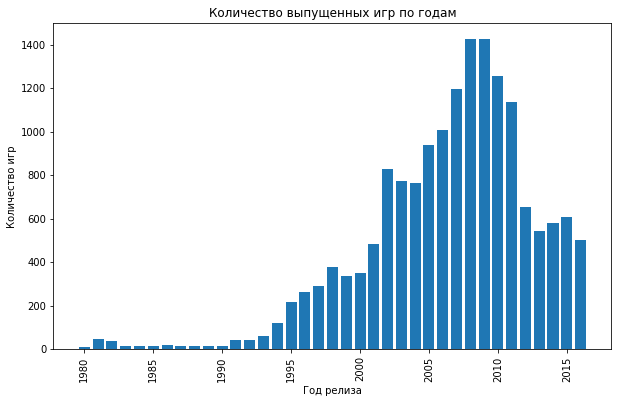

In [33]:
plt.figure(figsize=(10, 6))
plt.bar(game_counts.index, game_counts.values)
plt.xlabel('Год релиза')
plt.ylabel('Количество игр')
plt.title('Количество выпущенных игр по годам')
plt.xticks(rotation=90)
plt.show()

На графике видно,что основная часть (95 %) данных находится в диапазоне 1996-2016. Начиная с 1996 года наблюдается значительное увеличение выпуска игр. Пик популярности игр наблюдается в диапазоне 2001-2011 гг.

In [34]:
cumulative_counts = game_counts.cumsum()
cumulative_counts

1980        9
1981       55
1982       91
1983      108
1984      122
1985      136
1986      157
1987      173
1988      188
1989      205
1990      221
1991      262
1992      305
1993      365
1994      486
1995      705
1996      968
1997     1257
1998     1636
1999     1974
2000     2324
2001     2806
2002     3635
2003     4410
2004     5172
2005     6111
2006     7117
2007     8314
2008     9741
2009    11167
2010    12422
2011    13558
2012    14210
2013    14754
2014    15335
2015    15941
2016    16443
Name: year_of_release, dtype: int64

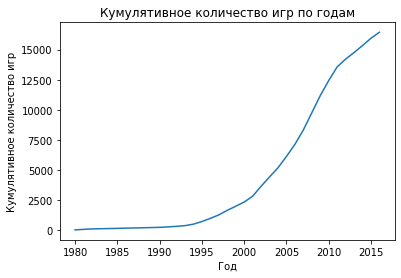

In [35]:
plt.plot(cumulative_counts.index, cumulative_counts.values)
plt.title('Кумулятивное количество игр по годам')
plt.xlabel('Год')
plt.ylabel('Кумулятивное количество игр')
plt.show()

### Посмотрим, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [36]:
games = games.drop(games[(games['platform'] == 'DS') & (games['year_of_release'] == 1985)].index)

In [37]:
platform_sales = games.groupby(['platform', 'year_of_release']).sum()[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]
platform_sales['total_sales'] = platform_sales.sum(axis=1)
platform_sales

na_sales  eu_sales  jp_sales  other_sales  \
platform year_of_release                                              
2600     1980                10.59      0.67      0.00         0.12   
         1981                33.40      1.96      0.00         0.32   
         1982                26.92      1.65      0.00         0.31   
         1983                 5.44      0.34      0.00         0.06   
         1984                 0.26      0.01      0.00         0.00   
...                            ...       ...       ...          ...   
XB       2008                 0.13      0.04      0.00         0.01   
XOne     2013                11.85      5.34      0.02         1.75   
         2014                30.97     18.15      0.14         4.81   
         2015                36.03     18.47      0.17         5.47   
         2016                14.27      9.63      0.01         2.24   

                          total_sales  
platform year_of_release               
2600     1980                   11.38  
         1981                   35.68  
         1982                   28.88  
         1983                    5.84  
         1984                    0.27  
...                               ...  
XB       2008                    0.18  
XOne     2013                   18.96  
         2014                   54.07  
         2015                   60.14  
         2016                   26.15  

[237 rows x 5 columns]

In [38]:
top_platforms = platform_sales.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index
top_platform_sales = platform_sales.loc[top_platforms]
top_platform_sales

na_sales  eu_sales  jp_sales  other_sales  \
platform year_of_release                                              
PS2      2000                16.08     10.64      8.87         3.58   
         2001                79.49     52.37     17.79        16.78   
         2002                96.54     65.27     21.85        21.72   
         2003                83.54     61.20     18.88        20.69   
         2004                96.78     56.01     19.17        39.85   
         2005                85.60     40.86     15.05        19.15   
         2006                49.93     21.61     17.64        14.24   
         2007                32.05     10.43      9.82        23.69   
         2008                21.23      7.63      5.73        19.31   
         2009                 9.36      4.94      1.94        10.16   
         2010                 2.19      1.54      0.71         1.20   
         2011                 0.13      0.13      0.09         0.10   
X360     2005                 6.90      0.43      0.28         0.64   
         2006                35.16     10.84      1.20         4.42   
         2007                62.99     22.17      1.52         8.73   
         2008                82.51     38.16      1.89        12.70   
         2009                74.00     33.31      1.95        11.03   
         2010               107.38     46.31      2.11        14.23   
         2011                86.75     42.58      1.78        12.73   
         2012                58.39     32.00      1.06         8.29   
         2013                53.36     27.03      0.43         7.76   
         2014                20.25     11.28      0.08         3.13   
         2015                 7.36      3.50      0.00         1.10   
         2016                 0.69      0.71      0.00         0.12   
PS3      2006                 8.84      7.38      1.08         3.66   
         2007                32.16     26.10      4.22        10.71   
         2008                57.23     38.73      5.82        16.74   
         2009                62.65     41.40      9.03        17.85   
         2010                60.99     50.50      9.87        20.81   
         2011                64.88     56.24     14.10        21.56   
         2012                39.88     39.04     11.94        16.49   
         2013                41.45     42.27     12.13        17.40   
         2014                16.39     18.24      6.25         6.88   
         2015                 4.99      6.04      3.67         2.12   
         2016                 0.67      1.26      1.30         0.37   
Wii      2006                70.86     43.62      9.15        13.52   
         2007                83.14     43.96     12.12        13.55   
         2008                97.12     46.52     12.69        14.99   
         2009               114.55     58.31     16.57        17.54   
         2010                72.64     36.31      8.78        10.22   
         2011                31.11     17.68      5.58         5.28   
         2012                10.89      5.99      3.34         1.49   
         2013                 4.48      3.34      0.05         0.72   
         2014                 1.59      1.86      0.00         0.30   
         2015                 0.43      0.62      0.00         0.09   
         2016                 0.06      0.11      0.00         0.01   
DS       2004                 8.33      3.93      3.65         1.36   
         2005                47.99     41.49     29.86        10.80   
         2006                50.01     23.07     38.56         8.17   
         2007                75.25     33.79     26.81        11.09   
         2008                78.12     32.24     24.01        10.94   
         2009                60.95     25.83     24.21         8.55   
         2010                40.80     18.82     19.86         5.54   
         2011                14.27      5.71      4.32         1.88   
         2012                 4.02      2.68      

Разобрались с таким артефактом у платформы DS как год выпуска игры 1985. Это ошибка, так как в 1985 году этой платформы еще не существовало. Визуализация помогает не только определять закономерности, но еще и находить ошибки.

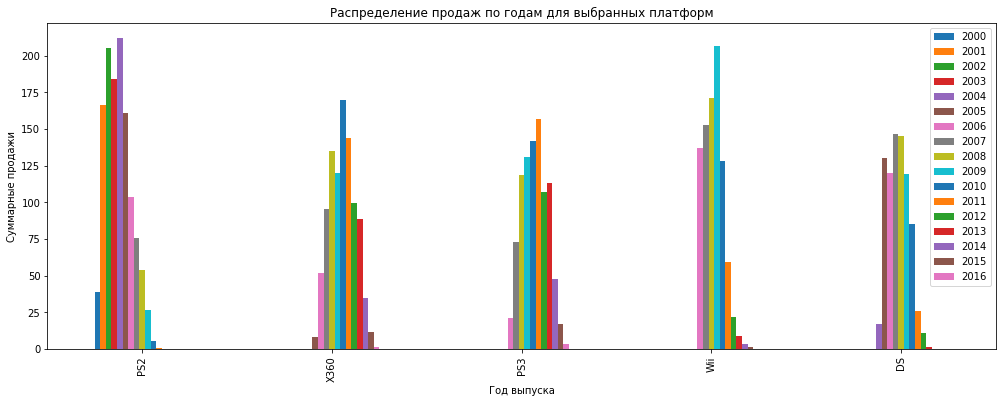

In [39]:
top_platform_sales.unstack()['total_sales'].plot(kind='bar', figsize=(17, 6))
plt.xlabel('Год выпуска')
plt.ylabel('Суммарные продажи')
plt.title('Распределение продаж по годам для выбранных платформ')
plt.legend(loc='upper right')
plt.show()

***За какой характерный срок появляются новые и исчезают старые платформы?***

- Появление новых платформ: на графике выше нужно обратить внимание на моменты, когда появляются новые платформы и начинаются их продажи .Это будет характеризоваться резким ростом продаж.

- Пиковый период: определить пиковый период для каждой платформы, когда продажи достигают максимального значения. Этот период является самым успешным для платформы.

- Снижение продаж: после пикового периода продажи платформы начинают снижаться. Нужно обратить внимание на моменты, когда продажи становятся ниже некоторого порога и продолжают падать.

- Исчезновение платформы: когда продажи платформы достигают очень низкого уровня и продолжают падать, можно считать, что платформа исчезает с рынка.

In [40]:
platform_lifetime = games.groupby('platform')['year_of_release'].agg(['min', 'max'])
platform_lifetime['lifetime'] = platform_lifetime['max'] - platform_lifetime['min']
average_lifetime = platform_lifetime['lifetime'].mean()
print("Средний срок жизни платформы:", average_lifetime)

Средний срок жизни платформы: 7.0


  
Средний срок жизни платформы составляет 7 лет. Это означает, что в игровой индустрии платформы обычно существуют в течение примерно 7 лет, после чего они выходят из активного производства и теряют популярность.

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы.


Если не учитывать данные за предыдущие годы и ограничиться только актуальным периодом, то в данном случае актуальным периодом будет рассматриваться период с 2012 по 2016 год. Этот период включает годы, в которых наблюдались пики продаж для выбранных платформ, и исключает предыдущие годы, которые уже не являются актуальными для прогнозирования продаж на 2017 год.

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

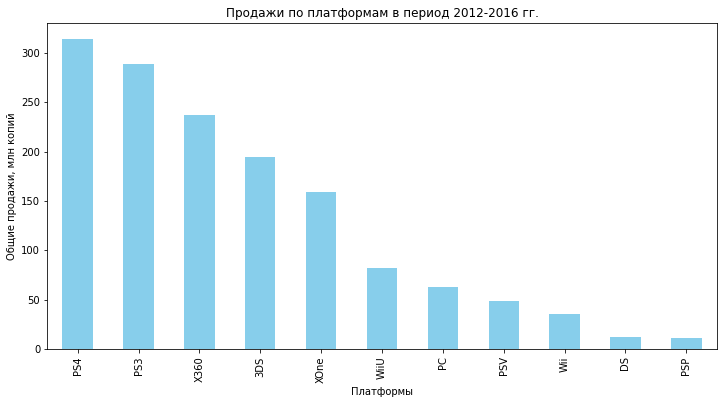

In [42]:
actual_period = games[(games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]
platform_sales = actual_period.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
platform_sales.plot(kind='bar', color='skyblue')
plt.title('Продажи по платформам в период 2012-2016 гг.')
plt.xlabel('Платформы')
plt.ylabel('Общие продажи, млн копий')
plt.xticks(rotation=90)
plt.show()

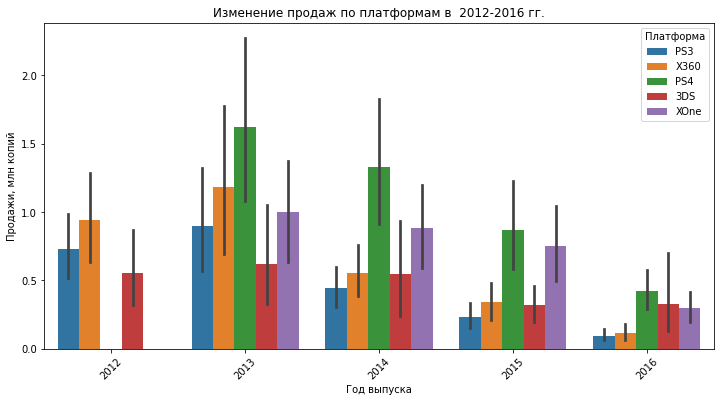

In [43]:
top_platforms = platform_sales.head(5).index
top_platform_trends = actual_period[actual_period['platform'].isin(top_platforms)]

plt.figure(figsize=(12, 6))
sns.barplot(data=top_platform_trends, x='year_of_release', y='total_sales', hue='platform')
plt.title('Изменение продаж по платформам в  2012-2016 гг.')
plt.xlabel('Год выпуска')
plt.ylabel('Продажи, млн копий')
plt.xticks(rotation=45)
plt.legend(title='Платформа')
plt.show()


С учетом данных о продажах по платформам в актуальном периоде, можно выделить 5 потенциально прибыльных платформ:
PlayStation 3 (PS3), Xbox 360 (X360), PS4,3DS,XOne. 

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

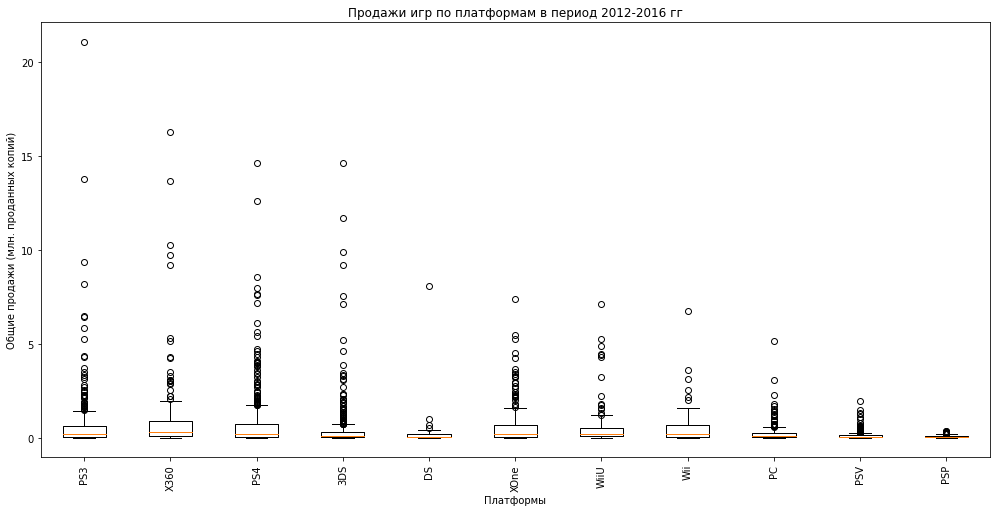

In [46]:
plt.figure(figsize=(17, 8))
plt.boxplot([actual_period[actual_period['platform'] == platform]['total_sales'] for platform in actual_period['platform'].unique()])
plt.title('Продажи игр по платформам в период 2012-2016 гг')
plt.xlabel('Платформы')
plt.ylabel('Общие продажи (млн. проданных копий)')
plt.xticks(range(1, len(actual_period['platform'].unique()) + 1), actual_period['platform'].unique(), rotation=90)
plt.show()

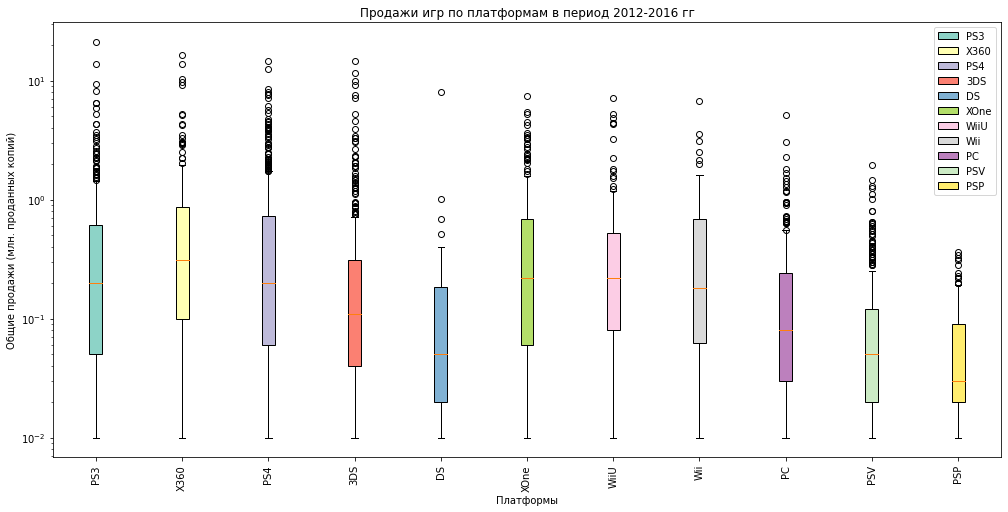

In [47]:
plt.figure(figsize=(17, 8))
platforms = actual_period['platform'].unique()

colors = plt.cm.Set3(np.linspace(0, 1, len(platforms)))

boxplots = []

for i, platform in enumerate(platforms):
    platform_sales = actual_period[actual_period['platform'] == platform]['total_sales']
    box = plt.boxplot(platform_sales, positions=[i + 1], patch_artist=True)
    boxplots.append(box['boxes'][0])
    box['boxes'][0].set_facecolor(colors[i])

plt.title('Продажи игр по платформам в период 2012-2016 гг')
plt.xlabel('Платформы')
plt.ylabel('Общие продажи (млн. проданных копий)')
plt.xticks(range(1, len(platforms) + 1), platforms, rotation=90)
plt.yscale('log')

plt.legend(boxplots, platforms)

plt.show()

***График "ящик с усами" (boxplot) для глобальных продаж игр в разбивке по платформам. Каждый ящик на графике представляет одну платформу, а его верхняя и нижняя границы показывают интерквартильный размах (межквартильный диапазон) данных. Линия внутри ящика представляет медиану (50-й процентиль), а "усы" указывают на область данных, не выходящих за пределы установленного диапазона.***

***Выбросы могут также указывать на неравномерность данных или наличие необычных событий или факторов, влияющих на продажи. В этом случае, анализ этих выбросов может помочь идентифицировать особенности рынка или особые обстоятельства, которые могут влиять на успех игр.***

***График "ящик с усами" позволяет визуально сравнивать продажи игр между разными платформами и оценивать их распределение и вариативность.***

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

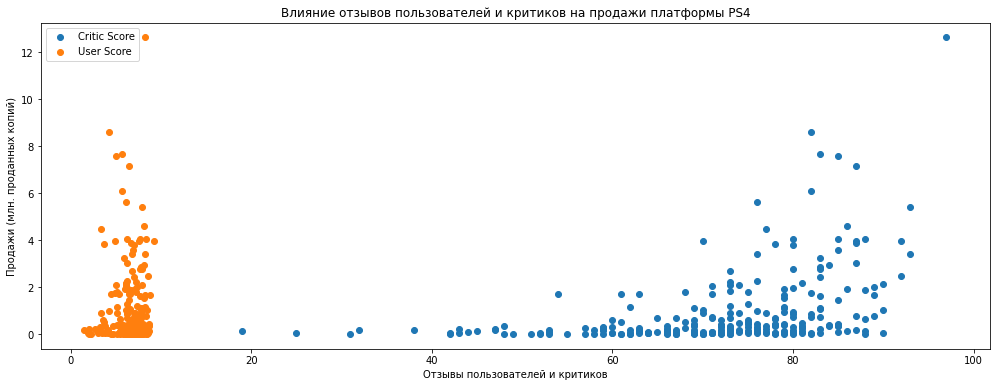

              critic_score  user_score  total_sales
critic_score      1.000000    0.385579     0.350407
user_score        0.385579    1.000000    -0.031957
total_sales       0.350407   -0.031957     1.000000


In [54]:
ps4_user_scores = actual_period[(actual_period['platform'] == 'PS4') & (actual_period['user_score'] != -1)]
ps4_critic_scores = actual_period[(actual_period['platform'] == 'PS4') & (actual_period['critic_score'] != -1)]

plt.figure(figsize=(17, 6))
plt.scatter(ps4_critic_scores['critic_score'], ps4_critic_scores['total_sales'], label='Critic Score')
plt.scatter(ps4_user_scores['user_score'], ps4_user_scores['total_sales'], label='User Score')
plt.title('Влияние отзывов пользователей и критиков на продажи платформы PS4')
plt.xlabel('Отзывы пользователей и критиков')
plt.ylabel('Продажи (млн. проданных копий)')
plt.legend()
plt.show()

correlation = ps4_user_scores[['critic_score', 'user_score', 'total_sales']].corr()
print(correlation)

In [55]:
print(len(actual_period[(actual_period['user_score'] != -1)]))
print(len(actual_period[(actual_period['critic_score'] != -1)]))
print(len(actual_period[(actual_period['user_score'] != -1) & (actual_period['critic_score'] != -1)]))

1530
1311
1296


Можно сделать следующие выводы: для платформы PS4 между оценками критиков и общими продажами наблюдается слабая положительная корреляция (0.35). Это может указывать на то, что более высокие оценки критиков связаны с более высокими продажами игр на платформе PS4. Однако стоит отметить, что связь не является сильной.

Между оценками пользователей и общими продажами наблюдается слабая отрицательная корреляция (-0.03). Это означает, что оценки пользователей не имеют сильного влияния на продажи игр на платформе PS4.

В целом, на основе данного анализа можно сказать, что оценки критиков могут оказывать некоторое влияние на продажи игр на платформе PS4, в то время как мнение пользователей не имеет существенного влияния на продажи. Однако, следует учитывать, что корреляция не обязательно означает причинно-следственную связь, и другие факторы также могут влиять на продажи игр.

### Соотнесите выводы с продажами игр на других платформах.

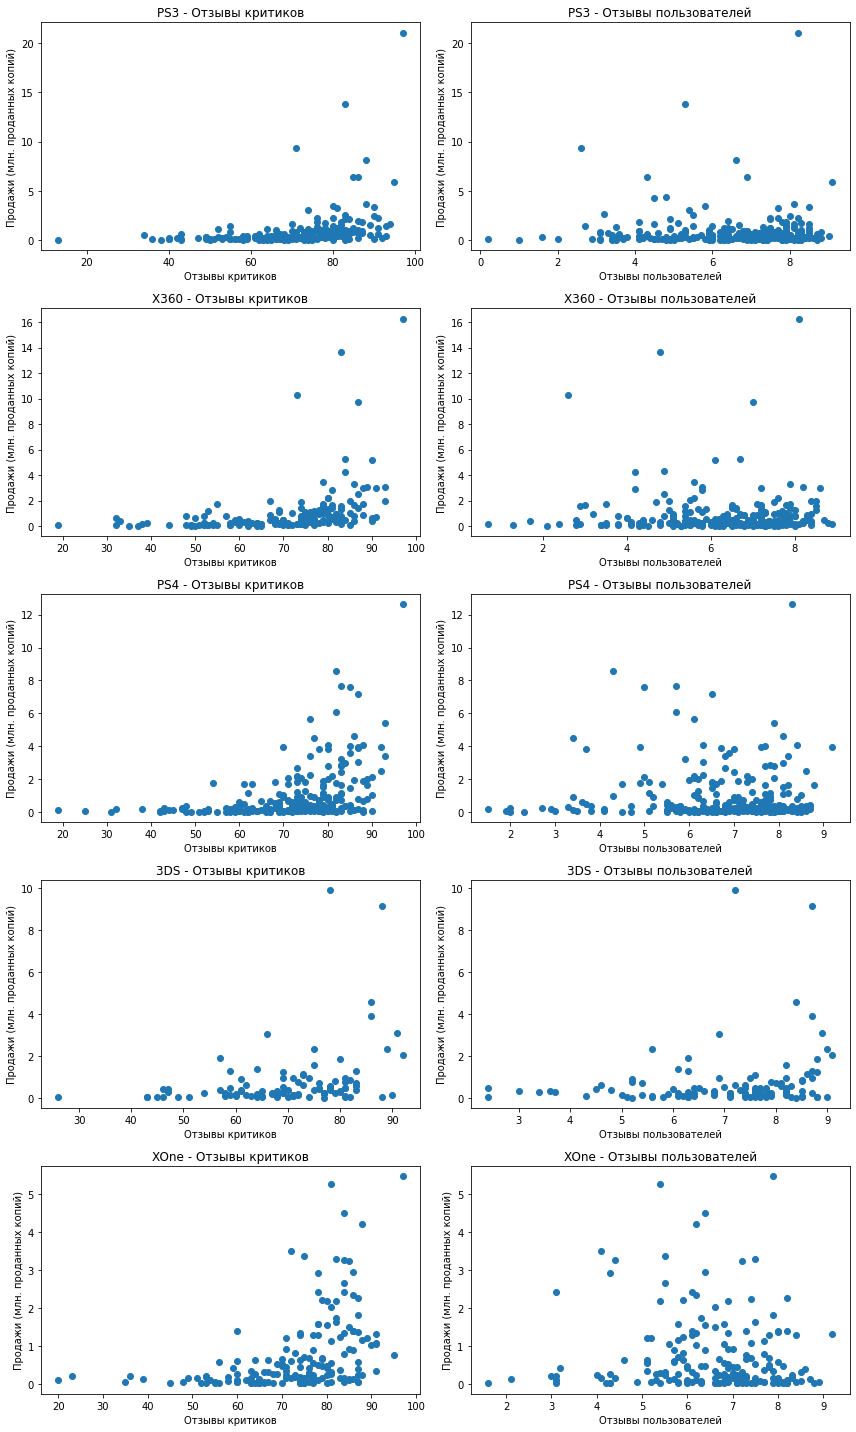

In [59]:
platforms = ['PS3', 'X360', 'PS4', '3DS', 'XOne']
fig, axes = plt.subplots(len(platforms), 2, figsize=(12, 20))

for i, platform in enumerate(platforms):
    platform_data = actual_period[actual_period['platform'] == platform]
    
    user_scores = platform_data[(platform_data['user_score'] != -1)]
    critic_scores = platform_data[(platform_data['critic_score'] != -1)]
    
    axes[i, 0].scatter(critic_scores['critic_score'], critic_scores['total_sales'])
    axes[i, 0].set_title(f'{platform} - Отзывы критиков')
    axes[i, 0].set_xlabel('Отзывы критиков')
    axes[i, 0].set_ylabel('Продажи (млн. проданных копий)')
   
    axes[i, 1].scatter(user_scores['user_score'], user_scores['total_sales'])
    axes[i, 1].set_title(f'{platform} - Отзывы пользователей')
    axes[i, 1].set_xlabel('Отзывы пользователей')
    axes[i, 1].set_ylabel('Продажи (млн. проданных копий)')

plt.tight_layout()
plt.show()

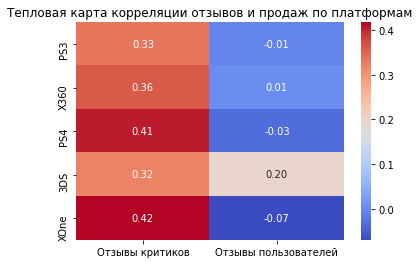

In [60]:
correlation_matrix = np.zeros((len(platforms), 2))
for i, platform in enumerate(platforms):
    platform_data = actual_period[actual_period['platform'] == platform]
    
    user_scores = platform_data[(platform_data['user_score'] != -1)]
    critic_scores = platform_data[(platform_data['critic_score'] != -1)]
    
    correlation_matrix[i, 0] = np.corrcoef(critic_scores['critic_score'], critic_scores['total_sales'])[0, 1]
    correlation_matrix[i, 1] = np.corrcoef(user_scores['user_score'], user_scores['total_sales'])[0, 1]

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", xticklabels=['Отзывы критиков', 'Отзывы пользователей'],
            yticklabels=platforms, cmap='coolwarm')
plt.title('Тепловая карта корреляции отзывов и продаж по платформам')
plt.show()

ps4_user_scores = actual_period[(actual_period['platform'] == 'PS4') & (actual_period['user_score'] != -1)]
ps4_critic_scores = actual_period[(actual_period['platform'] == 'PS4') & (actual_period['critic_score'] != -1)]

   Для большинства платформ (PS3, X360, PS4, 3DS, XOne) корреляция между отзывами критиков и продажами находится в диапазоне от 0.32 до 0.42. Это указывает на наличие некоторой положительной связи между отзывами критиков и продажами игр на этих платформах.

Корреляция между отзывами пользователей и продажами на данных платформах относительно низкая и близка к нулю (-0.07 до 0.20). Это говорит о том, что отзывы пользователей слабо связаны с объемом продаж игр.

Наиболее сильная связь между отзывами и продажами наблюдается для платформы XOne, где корреляция отзывов критиков составляет 0.42. Однако, стоит отметить, что эта связь все равно не является очень сильной.

Таким образом, результаты анализа указывают на то, что отзывы критиков могут иметь некоторое влияние на продажи игр на рассматриваемых платформах, в то время как отзывы пользователей имеют менее значимую связь с объемом продаж.


### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

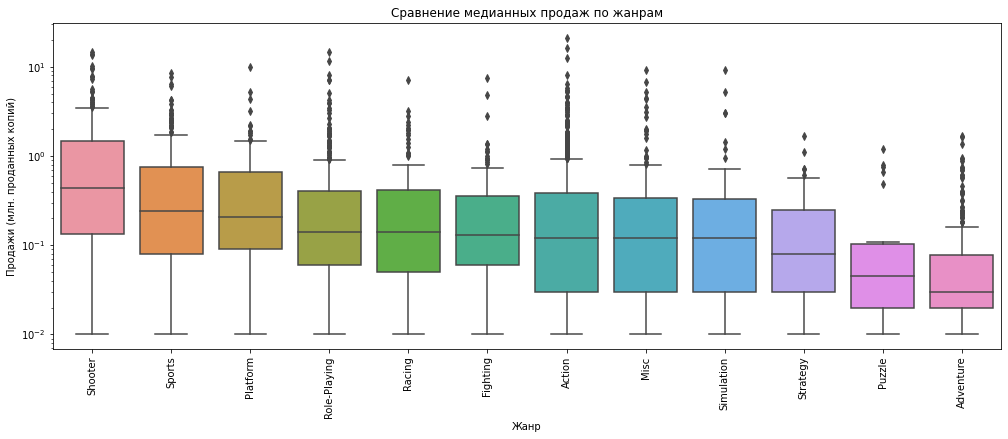

In [62]:
genre_sales = actual_period.groupby('genre')['total_sales'].median().sort_values(ascending=False)

plt.figure(figsize=(17, 6))
sns.boxplot(x=actual_period['genre'], y=actual_period['total_sales'], order=genre_sales.index)
plt.title('Сравнение медианных продаж по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи (млн. проданных копий)')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

   Таким образом, основываясь на медианах продаж, можно выделить жанры Shooter, Sports и Platform как самые прибыльные, а жанры Puzzle и Adventure как наименее прибыльные. Остальные жанры находятся в промежуточной группе с разными уровнями медианных продаж.
    
Однако, стоит отметить, что на боксплотах жанры имеют выбросы, то есть отдельные игры с очень высокими продажами, что может искажать общую картину. Поэтому важно учитывать и другие факторы, такие как средние значения, доли продаж и тенденции в разных жанрах.

## Составьте портрет пользователя каждого региона

### Определите для пользователя каждого региона (NA, EU, JP): Самые популярные платформы (топ-5). Опишите различия в долях продаж.

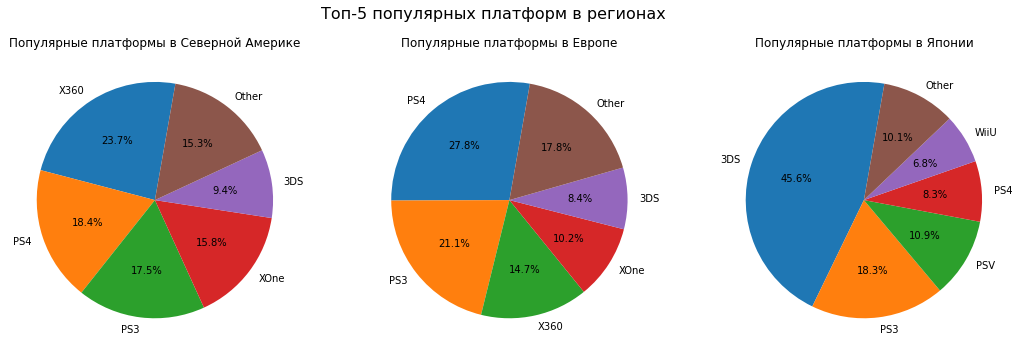

In [67]:
na_data = actual_period.groupby('platform')['na_sales'].sum().nlargest(5)
eu_data = actual_period.groupby('platform')['eu_sales'].sum().nlargest(5)
jp_data = actual_period.groupby('platform')['jp_sales'].sum().nlargest(5)

na_other = actual_period['na_sales'].sum() - na_data.sum()
eu_other = actual_period['eu_sales'].sum() - eu_data.sum()
jp_other = actual_period['jp_sales'].sum() - jp_data.sum()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

na_labels = na_data.index.tolist() + ['Other']
na_sizes = na_data.tolist() + [na_other]
axes[0].pie(na_sizes, labels=na_labels, autopct='%1.1f%%', startangle=80)
axes[0].set_title('Популярные платформы в Северной Америке')

eu_labels = eu_data.index.tolist() + ['Other']
eu_sizes = eu_data.tolist() + [eu_other]
axes[1].pie(eu_sizes, labels=eu_labels, autopct='%1.1f%%', startangle=80)
axes[1].set_title('Популярные платформы в Европе')

jp_labels = jp_data.index.tolist() + ['Other']
jp_sizes = jp_data.tolist() + [jp_other]
axes[2].pie(jp_sizes, labels=jp_labels, autopct='%1.1f%%', startangle=80)
axes[2].set_title('Популярные платформы в Японии')

fig.suptitle('Топ-5 популярных платформ в регионах', fontsize=16, y=0.95)
plt.show()

- В регионе NA (Северная Америка) самыми популярными платформами являются X360, PS2, Wii, PS3 и DS. 
- В регионе EU (Европа) наиболее популярными платформами являются PS2, PS3, X360, Wii и PS.
- В регионе JP (Япония) наибольшей популярностью пользуются платформы DS, PS, PS2, 3DS,PS3. 

В целом, можно заметить, что предпочтения в платформах различаются в разных регионах. Например, платформы X360 и Wii более популярны в Северной Америке, в то время как в Европе и Японии наиболее популярны платформы PS2, PS3 и DS. Эти различия могут быть связаны с предпочтениями и культурными особенностями игрового рынка в каждом регионе.

### Определите для пользователя каждого региона (NA, EU, JP): Самые популярные жанры (топ-5). Поясните разницу.

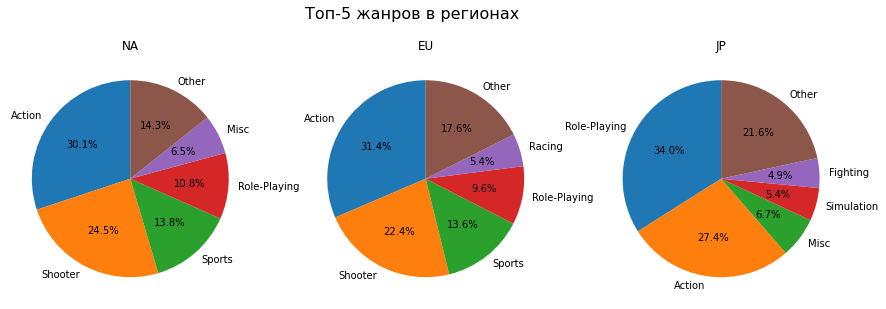

In [72]:
na_data = actual_period.groupby('genre')['na_sales'].sum().nlargest(5)
eu_data = actual_period.groupby('genre')['eu_sales'].sum().nlargest(5)
jp_data = actual_period.groupby('genre')['jp_sales'].sum().nlargest(5)

na_other = actual_period['na_sales'].sum() - na_data.sum()
eu_other = actual_period['eu_sales'].sum() - eu_data.sum()
jp_other = actual_period['jp_sales'].sum() - jp_data.sum()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

na_labels = na_data.index.tolist() + ['Other']
na_sizes = na_data.tolist() + [na_other]
axes[0].pie(na_sizes, labels=na_labels, autopct='%1.1f%%', startangle=90)
axes[0].set_title('NA')

eu_labels = eu_data.index.tolist() + ['Other']
eu_sizes = eu_data.tolist() + [eu_other]
axes[1].pie(eu_sizes, labels=eu_labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('EU')

jp_labels = jp_data.index.tolist() + ['Other']
jp_sizes = jp_data.tolist() + [jp_other]
axes[2].pie(jp_sizes, labels=jp_labels, autopct='%1.1f%%', startangle=90)
axes[2].set_title('JP')

fig.suptitle('Топ-5 жанров в регионах', fontsize=16)
plt.show()

В регионе NA (Северная Америка) самыми популярными жанрами являются Action, Sports, Shooter,Misc,Racing. Это указывает на то, что игроки в Северной Америке предпочитают игры с динамичным геймплеем, спортивные симуляторы, шутеры, гонки и игры из разных жанров (Misc).

В регионе EU (Европа) самыми популярными жанрами также являются Action, Sports, Shooter, Racing и Misc. Это указывает на схожие предпочтения с регионом NA, где игроки в Европе также предпочитают динамичные игры, спортивные симуляторы, шутеры, гонки и игры из разных жанров.

В регионе JP (Япония) самыми популярными жанрами являются Role-Playing, Action, Sports, Platform и Misc. Здесь мы видим некоторые различия в предпочтениях, где японские игроки больше склонны к играм ролевого жанра (Role-Playing), а также предпочитают игры с динамичным геймплеем (Action), спортивные игры (Sports), платформеры (Platform) и игры из разных жанров (Misc).

Таким образом, различия в популярных жанрах в каждом регионе отражают предпочтения игроков и культурные особенности каждого региона.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

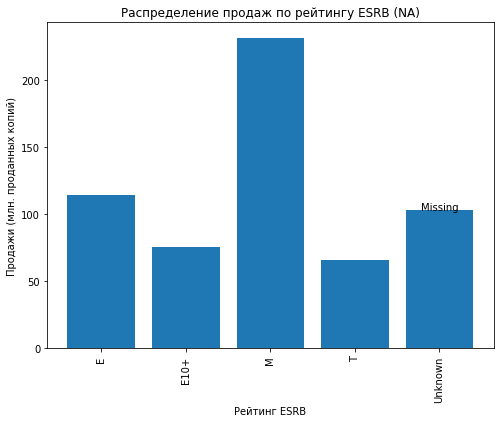

In [81]:
esrb_sales = actual_period.groupby('rating')['na_sales'].sum()

missing_sales = actual_period.loc[actual_period['rating'] == 'Unknown', 'na_sales'].sum()
esrb_sales.loc['Unknown'] = missing_sales

plt.figure(figsize=(8, 6))
plt.bar(esrb_sales.index.astype(str), esrb_sales)
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи (млн. проданных копий)')
plt.title('Распределение продаж по рейтингу ESRB (NA)')
plt.xticks(rotation=90)

plt.text('Unknown', missing_sales, 'Missing', ha='center')
plt.show()

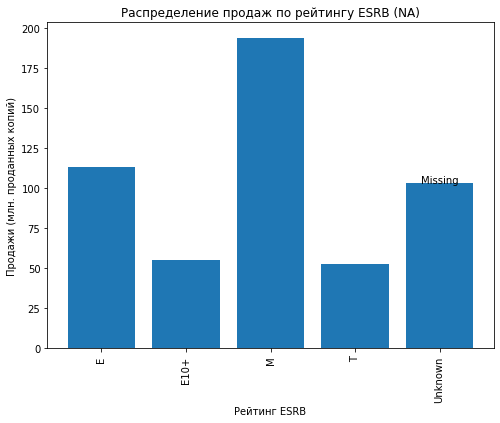

In [83]:
esrb_sales = actual_period.groupby('rating')['eu_sales'].sum()

missing_sales = actual_period.loc[actual_period['rating'] == 'Unknown', 'na_sales'].sum()
esrb_sales.loc['Unknown'] = missing_sales

plt.figure(figsize=(8, 6))
plt.bar(esrb_sales.index.astype(str), esrb_sales)
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи (млн. проданных копий)')
plt.title('Распределение продаж по рейтингу ESRB (NA)')
plt.xticks(rotation=90)

plt.text('Unknown', missing_sales, 'Missing', ha='center')
plt.show()

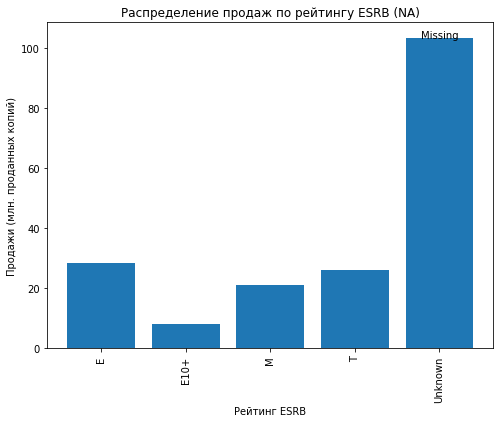

In [84]:
esrb_sales = actual_period.groupby('rating')['jp_sales'].sum()

missing_sales = actual_period.loc[actual_period['rating'] == 'Unknown', 'na_sales'].sum()
esrb_sales.loc['Unknown'] = missing_sales

plt.figure(figsize=(8, 6))
plt.bar(esrb_sales.index.astype(str), esrb_sales)
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи (млн. проданных копий)')
plt.title('Распределение продаж по рейтингу ESRB (NA)')
plt.xticks(rotation=90)

plt.text('Unknown', missing_sales, 'Missing', ha='center')
plt.show()

    
Самыми продаваемыми играми являются игры с рейтингом E (Everyone).За играми с рейтингом T (Teen) также наблюдается значительный спрос.Игры с рейтингом M (Mature) имеют более низкие продажи.Таким образом, можно сделать вывод, что рейтинг ESRB влияет на предпочтения игроков и продажи игр в отдельном регионе. Различные регионы могут иметь разные предпочтения и спрос на игры с определенными рейтингами.


## Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**Нулевая гипотеза (H0):** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Альтернативная гипотеза (H1):** Средние пользовательские рейтинги платформ Xbox One и PC различаются.

Выбираем уровень значимости 0.05.

Выполним статистический тест t-тест Стьюдента для независимых выборок. В данном случае, сравниваются две независимые выборки (рейтинги для Xbox One и PC).

In [87]:
xbox_one_ratings = actual_period[(actual_period['platform'] == 'XOne') & (actual_period['user_score'] != -1)]['user_score']
pc_ratings = actual_period[(actual_period['platform'] == 'PC') & (actual_period['user_score'] != -1)]['user_score']

results = stats.ttest_ind(xbox_one_ratings, pc_ratings, equal_var=False)

p_value = results.pvalue
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC различаются.")
else:
    print("Не отвергаем нулевую гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.")

p-value: 0.5489537965134912
Не отвергаем нулевую гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.


### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.


**Нулевая гипотеза (H0):** Средние пользовательские рейтинги жанров Action и Sports одинаковы.

**Альтернативная гипотеза (H1):** Средние пользовательские рейтинги жанров Action и Sports различаются.

Выбираем уровень значимости 0.05

Для проверки гипотез использован критерий t-теста (Student's t-test) для двух независимых выборок. Мы выбрали данный критерий, потому что у нас есть две независимые выборки (рейтинги для жанров Action и Sports) и мы хотим сравнить средние значения между ними. Параметр equal_var=False указывает на то, что мы предполагаем, что дисперсии выборок различны.

Для принятия решения о принятии или отвержении нулевой гипотезы, мы сравниваем полученное p-value со значением alpha. Если p-value меньше alpha, то мы отвергаем нулевую гипотезу и делаем вывод о наличии статистически значимого различия между средними значениями пользовательских рейтингов для жанров Action и Sports.

In [89]:
action_ratings = actual_period[(actual_period['genre'] == 'Action') & (actual_period['user_score'] != -1)]['user_score']
sports_ratings = actual_period[(actual_period['genre'] == 'Sports') & (actual_period['user_score'] != -1)]['user_score']

alpha = 0.05

t_statistic, p_value = stats.ttest_ind(action_ratings, sports_ratings, equal_var=False)

print("Средний пользовательский рейтинг для жанра Action:", action_ratings.mean())
print("Средний пользовательский рейтинг для жанра Sports:", sports_ratings.mean())
print()

print("p-value:", p_value)
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Средние пользовательские рейтинги жанров Action и Sports разные.")
else:
    print("Не отвергаем нулевую гипотезу. Средние пользовательские рейтинги жанров Action и Sports одинаковые.")

Средний пользовательский рейтинг для жанра Action: 6.825047801147227
Средний пользовательский рейтинг для жанра Sports: 5.455670103092784

p-value: 5.989458066467418e-20
Отвергаем нулевую гипотезу. Средние пользовательские рейтинги жанров Action и Sports разные.


Используя заданный пороговый уровень значимости alpha = 0.05, и получив p-value = 0.5697, мы не можем отвергнуть нулевую гипотезу. Это означает, что нет статистически значимых доказательств, чтобы считать, что средние пользовательские рейтинги жанров Action и Sports различаются. Мы не можем сделать вывод о том, что существует значимая разница в рейтингах между этими жанрами на основе проведенного теста.

In [90]:
print("Средний пользовательский рейтинг для жанра Action:", action_ratings.mean())
print("Средний пользовательский рейтинг для жанра Sports:", sports_ratings.mean())
print()
print("Средний пользовательский рейтинг для платформы Xbox One:", xbox_one_ratings.mean())
print("Средний пользовательский рейтинг для платформы PC:", pc_ratings.mean())
print()

Средний пользовательский рейтинг для жанра Action: 6.825047801147227
Средний пользовательский рейтинг для жанра Sports: 5.455670103092784

Средний пользовательский рейтинг для платформы Xbox One: 6.521428571428572
Средний пользовательский рейтинг для платформы PC: 6.4286407766990274



Средний пользовательский рейтинг для жанра Action составляет примерно 6.82, в то время как для жанра Sports - около 5.45. Это указывает на  различие в предпочтениях пользователей между этими жанрами. Жанр Action имеет немного более высокий рейтинг.

Средний пользовательский рейтинг для платформы Xbox One составляет около 6.52, в то время как для платформы PC - около 6.42. Это указывает на различия в оценке пользователей для этих двух платформ. Пользователи PC склонны давать немного более высокие рейтинги по сравнению с пользователями Xbox One.

Таким образом, можно сказать, что существуют некоторые различия в средних пользовательских рейтингах между жанрами Action и Sports, а также между платформами Xbox One и PC.

### **<p style="text-align: center;">Итоговый вывод.</p>**
    
***Мы можем использовать результаты анализа, чтобы определить, на какие игры следует потратить рекламный бюджет. Вот предложения, которые могут помочь в принятии решения:***

- **Платформы.** Исходя из анализа, рекомендуется сосредоточиться на платформах Xbox One и PS4. Эти платформы являются одними из самых популярных в целевых регионах (Северная Америка, Европа). Они имеют большую базу пользователей и потенциал для успешных продаж игр.

- **Жанры.** Популярные жанры, на которые стоит обратить внимание, включают Action, Sports, Shooter и Racing. Эти жанры имеют высокий спрос в Северной Америке и Европе. Игры в этих жанрах обычно имеют динамичный геймплей и широкую аудиторию.

- **Рейтинг ESRB.** Рекомендуется обращать внимание на игры с рейтингом E (Everyone) и T (Teen). Эти рейтинги наиболее популярны среди игроков и имеют больший потенциал для успешных продаж.

- **Регионы.** Северная Америка и Европа являются наиболее перспективными регионами для рекламы игр. Обратите особое внимание на эти регионы при планировании рекламной кампании.

- **Отзывы.** Отзывы пользователей могут дать дополнительную информацию о качестве игр. Рекомендуется учитывать положительные отзывы и высокие пользовательские рейтинги при выборе игр для рекламы. Хорошие отзывы могут помочь привлечь больше пользователей и увеличить продажи.

Итак, при планировании рекламного бюджета рекомендуется сфокусироваться на играх для платформ Xbox One и PS4 в жанрах Action, Sports, Shooter и Racing с рейтингами E и T. Северная Америка и Европа будут приоритетными регионами для рекламы. Учитывайте также положительные пользовательские отзывы для выбора успешных игр.    
